In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from pnr_utils import *
from plot_imports import *

In [30]:
# to reload modules without restarting kernel (optional)
from importlib import reload
import sys
reload(sys.modules['pnr_utils'])
reload(sys.modules['plot_imports'])
from pnr_utils import *
from plot_imports import *

In [2]:
# set data properties
sample_name = 'BiSe10_EuS5' #'CrO20_BiSbTe20'
dataset = 4
fit_roughness = False

In [3]:
# get directories
set_dir = 'results/' + sample_name + '/set_' + str(dataset)
data_dir = set_dir + '/data'
image_dir = set_dir + '/properties'

if not os.path.exists(image_dir):
    os.makedirs(image_dir)

print('data:', set_dir)

data: results/BiSe10_EuS5/set_4


In [4]:
# data settings
layers, rho, M, N, q_min, q_max = parse_metadata(set_dir)
q = 10*np.linspace(q_min, q_max, N)

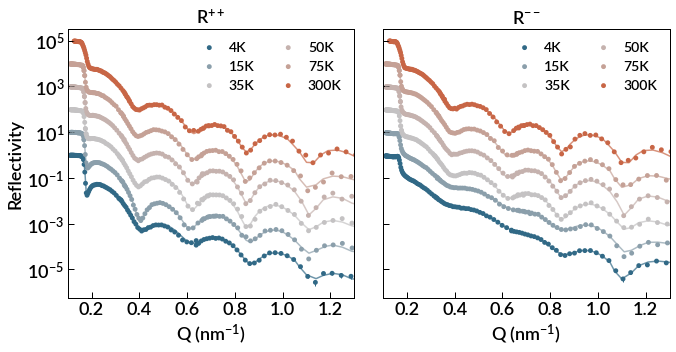

In [5]:
# plot experiment
exp_names = next(os.walk('experiments/' + sample_name))[1]
exp_names = [k for k in exp_names if '-' not in k]
exp_names = [exp_names[j] for j in np.argsort([int(i[:i.index('K')]) for i in exp_names])]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9.5,5), sharey=True)
prop_text = prop.copy()
prop_text.set_size(14)

temps = [int(k[:-1]) for k in exp_names]
norm = mpl.colors.LogNorm(vmin=min(temps), vmax=max(temps))
for i in range(len(exp_names)):
    xdata_uu = 'experiments/' + sample_name + '/' + exp_names[i] + '/x_uu.dat'
    xdata_dd = 'experiments/' + sample_name + '/' + exp_names[i] + '/x_dd.dat'
    xdata_fit = 'experiments/' + sample_name + '/' + exp_names[i] + '/x_fit.csv'
    df_uu = read_exp(xdata_uu)
    df_dd = read_exp(xdata_dd)
    df_fit = pd.read_csv(xdata_fit)

    # we use the lowest temperature measurement for noise estimates
    if i==0: q_exp = 10*df_uu['Q'].values

    ax1.errorbar(10*df_uu['Q'].values, 10**i*df_uu['R'].values, yerr=df_uu['dR'].values, lw=0, elinewidth=1,
                 color=cmap_temp(norm(temps[i])))
    ax2.errorbar(10*df_dd['Q'].values, 10**i*df_dd['R'].values, yerr=df_dd['dR'].values, lw=0, elinewidth=1,
                 color=cmap_temp(norm(temps[i])))
    ax1.scatter(10*df_uu['Q'].values, 10**i*df_uu['R'].values, s=24, color=cmap_temp(norm(temps[i])),
                ec='none', label=exp_names[i])
    ax2.scatter(10*df_dd['Q'].values, 10**i*df_dd['R'].values, s=24, color=cmap_temp(norm(temps[i])),
                ec='none', label=exp_names[i])
    ax1.plot(10*df_fit['x'], 10**i*df_fit['y_uu'], color=cmap_temp(norm(temps[i])), alpha=0.7)
    ax2.plot(10*df_fit['x'], 10**i*df_fit['y_dd'], color=cmap_temp(norm(temps[i])), alpha=0.7)

ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.legend(frameon=False, ncol=2, prop=prop_text, loc='upper right', columnspacing=1.4, handletextpad=0.4)
ax2.legend(frameon=False, ncol=2, prop=prop_text, loc='upper right', columnspacing=1.4, handletextpad=0.4)

format_axis(ax1, 'Q (nm$^{-1}$)', 'Reflectivity', prop, 'R$^{++}$', xlims=[q.min(), q.max()])
format_axis(ax2, 'Q (nm$^{-1}$)', ' ', prop, 'R$^{--}$', xlims=[q.min(), q.max()])

fig.tight_layout()
fig.subplots_adjust(wspace=0.1)
fig.savefig(image_dir + '/pnr_experiment.pdf')

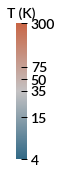

In [6]:
# save colorbar
sm = mpl.cm.ScalarMappable(cmap=cmap_temp, norm=norm)
sm.set_array([])

fig, ax = plt.subplots(figsize=(0.21,2.5))
cbar = fig.colorbar(sm, cax=ax, ticks=temps)
cbar.ax.set_title('T (K)', fontproperties=prop_text)
cbar.ax.tick_params(direction='in', length=6, width=1)
for lab in cbar.ax.get_yticklabels():
    lab.set_fontproperties(prop_text)
cbar.ax.set_yticklabels([str(i) for i in temps])
cbar.ax.minorticks_off()
cbar.outline.set_visible(False)

fontsize = 16
format_axis(cbar.ax, '', '', prop_text)
fig.savefig(image_dir + '/pnr_experiment_cbar.pdf', bbox_inches='tight')

In [7]:
# parse synthetic data
xdata_uu =  data_dir + '/xdata_uu.txt'
xdata_dd =  data_dir + '/xdata_dd.txt'
ydata =  data_dir + '/ydata.txt'

x_uu = pd.read_csv(xdata_uu, header=None, sep=' ', dtype=float).values
x_dd = pd.read_csv(xdata_dd, header=None, sep=' ', dtype=float).values
x = np.stack([x_uu, x_dd], axis=2)

df = pd.read_csv(ydata, dtype=float)
df['class_prox'] = (df['magn_prox'] > 0).astype(int)
y = df['class_prox'].values
y_data, y_columns, y_header, y_ids, y_labels, y_units = parse_labels(df, fit_roughness)

In [8]:
# organize dataframe of parameter values
layer = []
for l in layers:
    layer += [l]*len(df)

df.loc[df['class_prox']==0, 'class_prox'] = 'no proximity'
df.loc[df['class_prox']==1, 'class_prox'] = 'with proximity'

df = pd.DataFrame({'layer': layer,
                   'dens': np.concatenate([df[col].values for col in df.columns if col.startswith('dens_')]),
                   'd': np.concatenate([df[col].values for col in df.columns if col.startswith('d_')]),
                   's': np.concatenate([df[col].values for col in df.columns if col.startswith('s_')]),
                   'magn': np.concatenate([df[col].values for col in df.columns if col.startswith('magn_')]),
                   'class_prox': np.tile(df['class_prox'].values, len(layers))})

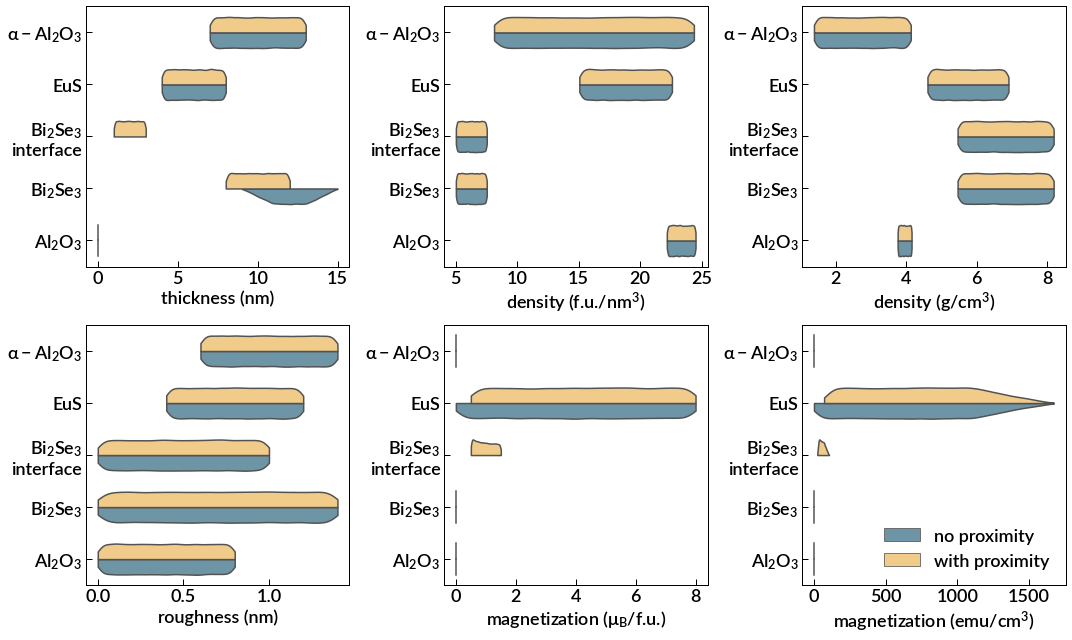

In [9]:
# plot parameter ranges
u = 1.66054
df['M'] = df['layer'].map(lambda x: M[layers.index(x)])

# sampled density in g/cm^3
df['rho'] = df['dens']*u*df['M']/1e3

# magnetization in emu/cm^3
df['magn_'] = df['magn']*df['dens']*9.274

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(15,9))
ylabels = ['thickness (nm)', 'density (f.u./'+r'$nm^3$)', 'density (g/'+r'$cm^3$)',
           'roughness (nm)', 'magnetization ('+r'$\mu_B$/f.u.)', 'magnetization ('+r'$emu/cm^3$)']

for i, (param, ax, ylabel) in enumerate(zip(['d', 'dens', 'rho', 's', 'magn', 'magn_'],
                                            [ax1, ax2, ax3, ax4, ax5, ax6], ylabels)):

    g = sns.violinplot(ax=ax, x=param, y='layer', hue='class_prox', split=True, inner=None, cut=0, width=0.6,
                       scale='count', saturation=0.9, data=df,
                       palette={'with proximity': cmap_disc_light(1), 'no proximity': cmap_disc_light(0)})
    g.legend_.remove()
    ax.invert_yaxis()    
    format_axis(ax, ylabel, '', prop)

ax6.legend(prop=prop, frameon=False, loc='lower right')
fig.tight_layout()
fig.savefig(image_dir + '/parameters.pdf')

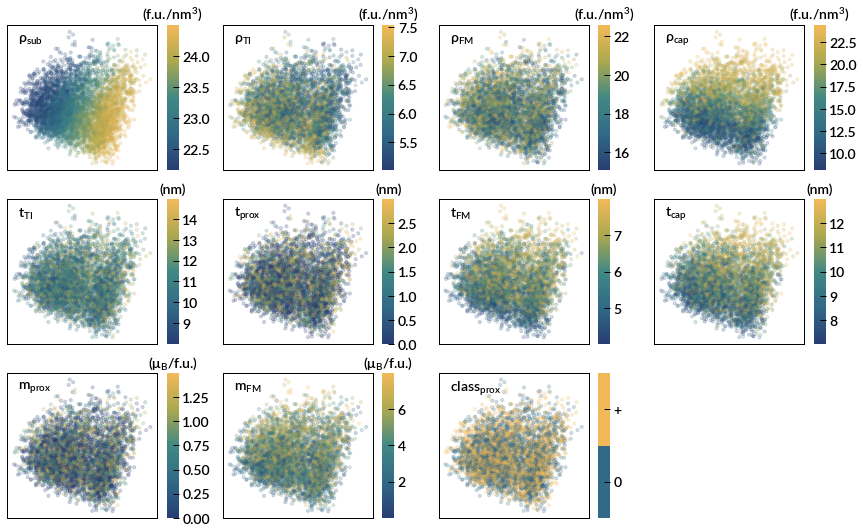

In [10]:
# visualize separability by PCA on x-values
plot_latent_representation(image_dir, x.reshape(x.shape[0],-1), y_data, y_ids, y_labels, y_units, 'properties',
                           mode=0)

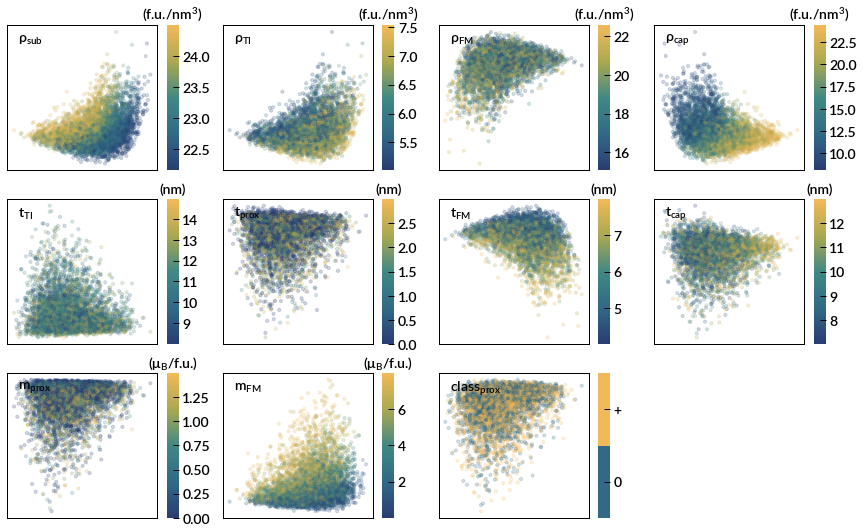

In [11]:
# visualize separability by PCA on y-values
plot_latent_representation(image_dir, x.reshape(x.shape[0],-1), y_data, y_ids, y_labels, y_units, 'properties',
                           mode=1)

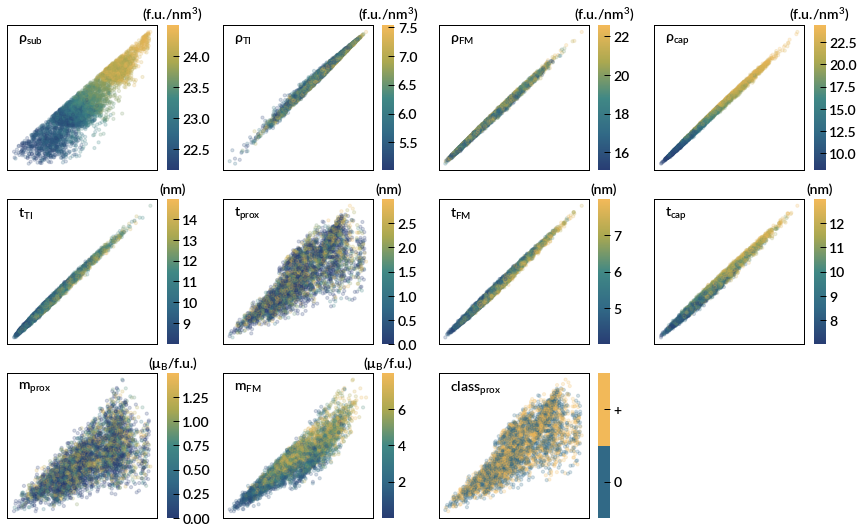

In [12]:
# visualize separability by gradient on y-values
plot_latent_representation(image_dir, x.reshape(x.shape[0],-1), y_data, y_ids, y_labels, y_units, 'properties',
                           mode=2)

In [13]:
prop.set_size(18)

# separate positive and negative examples
i_pos = np.nonzero(y)[0]
i_neg = np.nonzero(y - 1)[0]

# select first num_examples examples to plot
num_examples = 20

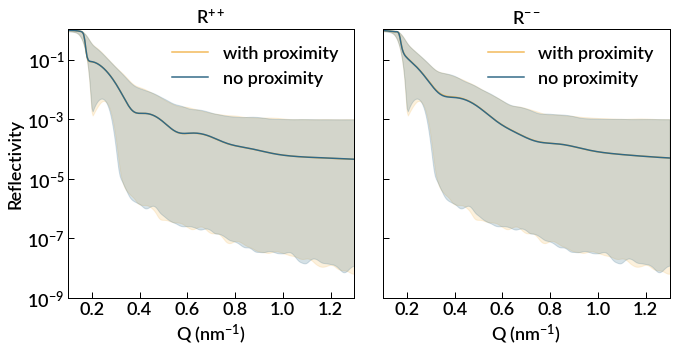

In [14]:
# plot summary of synthetic data
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9.5,5), sharey=True)
for i, label, color in zip([i_pos, i_neg], ['with proximity', 'no proximity'], [cmap_disc(1), cmap_disc(0)]):
    x_uu_avg = np.mean(x[i,:,0], axis=0)
    x_uu_min = np.min(x[i,:,0], axis=0)
    x_uu_max = np.max(x[i,:,0], axis=0)

    x_dd_avg = np.mean(x[i,:,1], axis=0)
    x_dd_min = np.min(x[i,:,1], axis=0)
    x_dd_max = np.max(x[i,:,1], axis=0)

    ax1.plot(q, x_uu_avg, color=color, label=label)
    ax1.fill_between(q, smooth_data(x_uu_max, int(N/32.)), y2=smooth_data(x_uu_min, int(N/32.)),
                     color=color, alpha=0.2)

    ax2.plot(q, x_dd_avg, color=color, label=label)
    ax2.fill_between(q, smooth_data(x_dd_max, int(N/32.)), y2=smooth_data(x_uu_min, int(N/32.)),
                     color=color, alpha=0.2)

ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.legend(prop=prop, frameon=False)
ax2.legend(prop=prop, frameon=False)

format_axis(ax1, 'Q (nm$^{-1}$)', 'Reflectivity', prop, 'R$^{++}$', [q.min(), q.max()], [1e-9, 1.1])
format_axis(ax2, 'Q (nm$^{-1}$)', ' ', prop, 'R$^{--}$', [q.min(), q.max()], [1e-9, 1.1])

fig.tight_layout()
fig.subplots_adjust(wspace=0.1)
fig.savefig(image_dir + '/pnr_summary.pdf')

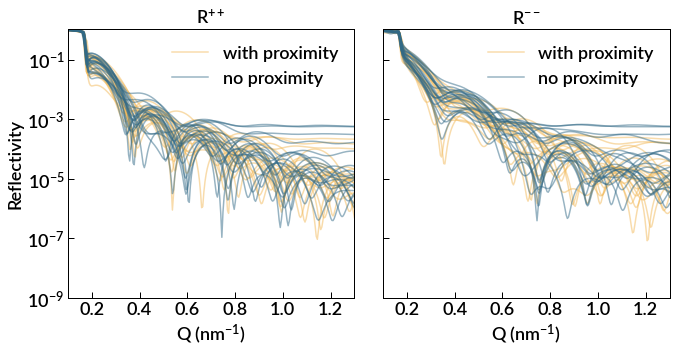

In [15]:
# plot example spectra
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9.5,5), sharey=True)
for i, label, color in zip([i_pos, i_neg], ['with proximity', 'no proximity'], [cmap_disc(1), cmap_disc(0)]):
    ax1.plot(q, x[i[0],:,0].T, color=color, alpha=0.5, label=label)
    ax1.plot(q, x[i[1:num_examples],:,0].T, color=color, alpha=0.5)

    ax2.plot(q, x[i[0],:,1].T, color=color, alpha=0.5, label=label)
    ax2.plot(q, x[i[1:num_examples],:,1].T, color=color, alpha=0.5)

ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.legend(prop=prop, frameon=False)
ax2.legend(prop=prop, frameon=False)

format_axis(ax1, 'Q (nm$^{-1}$)', 'Reflectivity', prop, 'R$^{++}$', [q.min(), q.max()], [1E-9, 1.1])
format_axis(ax2, 'Q (nm$^{-1}$)', ' ', prop, 'R$^{--}$', [q.min(), q.max()], [1E-9, 1.1])

fig.tight_layout()
fig.subplots_adjust(wspace=0.1)
fig.savefig(image_dir + '/pnr_examples.pdf')